In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [4]:
device = torch.device("mps:0" if torch.cuda.is_available() else "cpu")

In [5]:
train_dataset = torchvision.datasets.FashionMNIST("/Users/t08/works/deep_advance/data", download= True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("/Users/t08/works/deep_advance/data",download= True,train= False  ,transform=transforms.Compose([transforms.ToTensor()]))

100.0%
100.0%
100.0%
100.0%


In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

/var/folders/5f/52_6c3hx2fd137621mfxzxbw0000gq/T/ipykernel_1493/1338010056.py:11: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(img, cmap='gray')


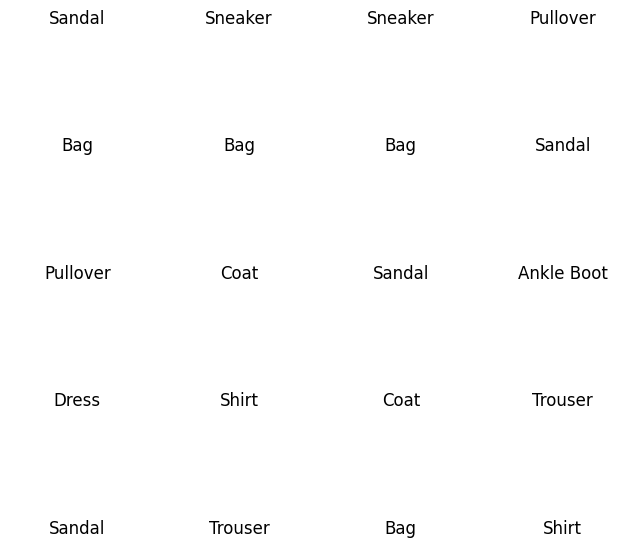

In [9]:
labels_map = {0 : 'T-Shirt' , 1 : 'Trouser', 2 : 'Pullover', 3: 'Dress', 4:'Coat', 5 : 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8 : 'Bag', 9: 'Ankle Boot'}
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns * rows + 1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:0,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [11]:

class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)   # ①
        self.drop = nn.Dropout(0.25)                              # ③
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data):                                # ④
        out = input_data.view(-1, 784)                            # ⑤
        out = F.relu(self.fc1(out))                               # ⑥
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [13]:
learing_rate =0.001;
model= FashionDNN();
model.to(device)
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr = learing_rate);
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [14]:
num_epochs = 5
count = 0
loss_list = []          # ①
iteration_list = []
accuracy_list = []
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:          # ②
        images, labels = images.to(device), labels.to(device)    # ③

        train = Variable(images.view(100, 1, 28, 28))            # ④
        labels = Variable(labels)

        outputs = model(train)   # 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):     # count를 50으로 나누었을 때 나머지가 0이 아니면 실행
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total     # ⑤
            loss_list.append(loss.data)          # ①'
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.6010146141052246, Accuracy: 83.77999877929688%
Iteration: 1000, Loss: 0.47975605726242065, Accuracy: 84.77999877929688%
Iteration: 1500, Loss: 0.3858988583087921, Accuracy: 83.7699966430664%
Iteration: 2000, Loss: 0.4019760489463806, Accuracy: 85.69999694824219%
Iteration: 2500, Loss: 0.27350783348083496, Accuracy: 86.31999969482422%
Iteration: 3000, Loss: 0.28803548216819763, Accuracy: 86.23999786376953%


In [29]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels =1, out_channels= 32, kernel_size= 3, padding= 1),
            nn.BatchNorm2d(32), #정규화
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2, stride=2) #최대풀링 2x2 , 스트라이드 2
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size = 3),
            nn.BatchNorm2d(64), #정규화
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features= 64*6*6, out_features= 600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features= 600, out_features= 120)
        self.fc3 = nn.Linear(in_features= 120, out_features= 10)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


In [30]:
learing_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr = learing_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [31]:
num_epochs = 5
count = 0
loss_list = []
iteration_list =[]
accuracy_list = []

predictions_list = []
labels_list = []
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device) 
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not(count % 500):
            print("Iteration : {} , loss ; {}, Accuracy : {}%".format(count, loss.data, accuracy))

/opt/anaconda3/envs/deep_env/lib/python3.12/site-packages/torch/nn/functional.py:1535: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration : 500 , loss ; 0.4260943531990051, Accuracy : 87.36000061035156%
Iteration : 1000 , loss ; 0.33869948983192444, Accuracy : 88.19999694824219%
Iteration : 1500 , loss ; 0.2829112112522125, Accuracy : 88.1500015258789%
Iteration : 2000 , loss ; 0.2220563292503357, Accuracy : 89.12999725341797%
Iteration : 2500 , loss ; 0.13227225840091705, Accuracy : 89.5%
Iteration : 3000 , loss ; 0.17734664678573608, Accuracy : 90.2300033569336%
